In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchsummary import summary
import os
import random
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import warnings

In [28]:
!unzip dataset.zip

Archive:  dataset.zip
replace dataset/test/Anthurium/image_01964.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/test/Anthurium/image_01964.jpg  
  inflating: dataset/test/Anthurium/image_01965.jpg  
  inflating: dataset/test/Anthurium/image_01968.jpg  
  inflating: dataset/test/Anthurium/image_01969.jpg  
  inflating: dataset/test/Anthurium/image_01971.jpg  
  inflating: dataset/test/Anthurium/image_01972.jpg  
  inflating: dataset/test/Anthurium/image_01973.jpg  
  inflating: dataset/test/Anthurium/image_01975.jpg  
  inflating: dataset/test/Anthurium/image_01977.jpg  
  inflating: dataset/test/Anthurium/image_01990.jpg  
  inflating: dataset/test/Anthurium/image_01991.jpg  
  inflating: dataset/test/Anthurium/image_01996.jpg  
  inflating: dataset/test/Anthurium/image_01997.jpg  
  inflating: dataset/test/Anthurium/image_01998.jpg  
  inflating: dataset/test/Anthurium/image_01999.jpg  
  inflating: dataset/test/Anthurium/image_02000.jpg  
  inflating: dataset/test/

In [29]:
# Define the dataset paths
train_path = '/content/dataset/train'
test_path = '/content/dataset/test'

In [30]:
# Define the classes in your dataset
classes = ['Olu', 'Rose', 'Temple flowers', 'Lotus', 'Daisy', 'Anthurium']

In [31]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(32,antialias=True),  # LeNet uses 32x32 input size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust mean and std for LeNet
    ]),
    'test': transforms.Compose([
        transforms.Resize(32, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust mean and std for LeNet
    ]),
}

In [32]:
def custom_collate_fn(batch):
    # Define the desired height and width dimensions
    height, width = 32, 32  # Change these dimensions to match your requirements

    # Get the data and labels from the batch
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Resize images to the defined height and width
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        data = [transforms.Resize((height, width), Image.BILINEAR)(image) for image in data]

    # Convert data and labels to tensors
    data = torch.stack(data)
    labels = torch.tensor(labels)

    return data, labels

In [33]:
# Create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(eval(f'{x}_path')), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2 , collate_fn=custom_collate_fn) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

**Create Model**

In [34]:
# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = LeNet(len(classes))
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 6]             510
Total params: 61,666
Trainable params: 61,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [35]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [36]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Function for training the model and recording metrics
def train_model(model, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            corrects = 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = corrects.double() / total_samples

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record metrics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accuracies.append(epoch_acc)


In [37]:
# Move the model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Train the model
train_model(model, criterion, optimizer, num_epochs=50)

# Save the trained model
torch.save(model.state_dict(), 'flower_recognition_model.pth')


Epoch 1/50
--------------------------------------------------
train Loss: 1.7873 Acc: 0.1902
test Loss: 1.7934 Acc: 0.1667
Epoch 2/50
--------------------------------------------------
train Loss: 1.7847 Acc: 0.1924
test Loss: 1.7936 Acc: 0.1700
Epoch 3/50
--------------------------------------------------
train Loss: 1.7824 Acc: 0.2024
test Loss: 1.7938 Acc: 0.1767
Epoch 4/50
--------------------------------------------------
train Loss: 1.7803 Acc: 0.2347
test Loss: 1.7942 Acc: 0.1767
Epoch 5/50
--------------------------------------------------
train Loss: 1.7779 Acc: 0.2303
test Loss: 1.7946 Acc: 0.1667
Epoch 6/50
--------------------------------------------------
train Loss: 1.7757 Acc: 0.2169
test Loss: 1.7947 Acc: 0.1667
Epoch 7/50
--------------------------------------------------
train Loss: 1.7742 Acc: 0.2158
test Loss: 1.7952 Acc: 0.1667
Epoch 8/50
--------------------------------------------------
train Loss: 1.7721 Acc: 0.2158
test Loss: 1.7957 Acc: 0.1667
Epoch 9/50
-----

**Final Result**

In [38]:
# Calculate and print the final loss and accuracy on the test dataset
model.eval()
running_loss = 0.0
corrects = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

final_loss = running_loss / dataset_sizes['test']
final_accuracy = corrects.double() / dataset_sizes['test']

print(f'Final Test Loss: {final_loss:.4f}')
print(f'Final Test Accuracy: {final_accuracy:.4f}')

Final Test Loss: 1.5568
Final Test Accuracy: 0.3033


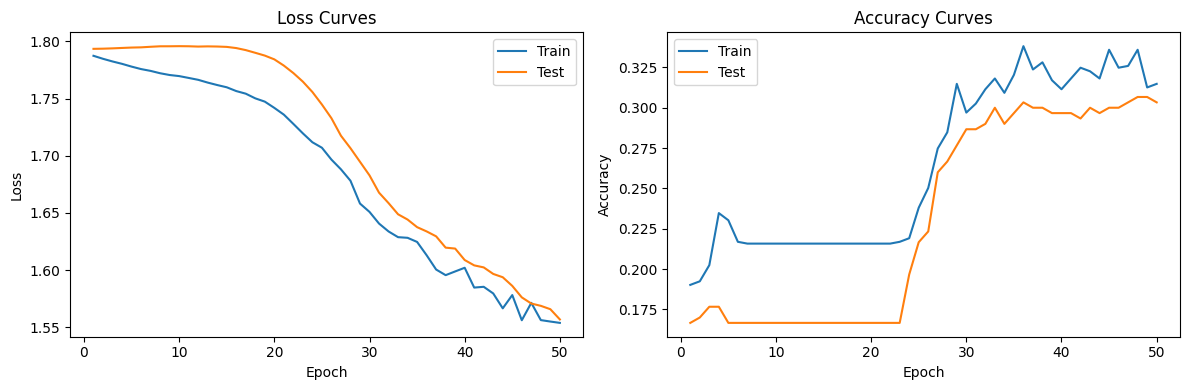

In [39]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

**Predicting Images**

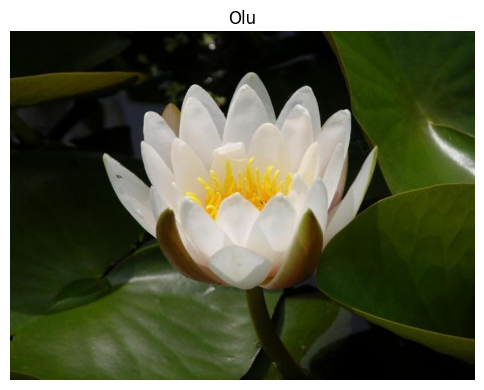

In [40]:
# List all image files in the directory
image_files = [os.path.join(train_path, flower_name, file_name)
               for flower_name in os.listdir(train_path)
               for file_name in os.listdir(os.path.join(train_path, flower_name))
               if file_name.endswith('.jpg') or file_name.endswith('.png')]  # Add more extensions as needed

# Choose a random image file from the list
random_image_path = random.choice(image_files)

# Get the corresponding flower type (directory name)
random_flower_type = os.path.basename(os.path.dirname(random_image_path))

# Open the selected random image
random_image = Image.open(random_image_path)

plt.figure(figsize=(6, 6))
plt.imshow(random_image)
plt.title(random_flower_type)  # Use random_flower_type here
plt.axis('off')
plt.show()